# OCT Image Alignment - BL & FUP

## Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy import ndimage

In [3]:
from scipy.ndimage import map_coordinates

In [4]:
DATA_DIR = 'data'

## Load images

In [10]:
# # run if needed
# img_fup = np.load(os.path.join(DATA_DIR, 'FUP/centered_image.npy'))
# fup_match_idx = np.load('fup_match_idx.npy')
# img_fup = img_fup[:,:,fup_match_idx]
# img_fup = np.linalg.norm(img_fup, axis=3)
# np.save(os.path.join(DATA_DIR, 'FUP/centered_image_gray.npy'), img_fup)

In [90]:
img_bl = np.load(os.path.join(DATA_DIR, 'BL/centered_image_gray.npy'))
img_fup = np.load(os.path.join(DATA_DIR, 'FUP/centered_image_gray.npy'))

In [91]:
img_bl = img_bl[200:800, 200:800]
img_fup = img_fup[200:800, 200:800]

In [ ]:
img_bl = (img_bl - img_bl.min(axis=(0,1))) / (img_bl.max(axis=(0,1)) - img_bl.min(axis=(0,1)))

In [ ]:
img_fup = (img_fup - img_fup.min(axis=(0,1))) / (img_fup.max(axis=(0,1)) - img_fup.min(axis=(0,1)))

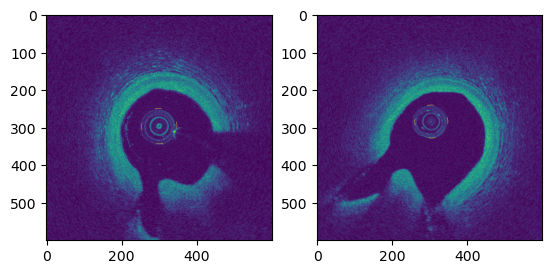

In [94]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(img_bl[:,:,200])
axes[1].imshow(img_fup[:,:,200])

## Gradient descent functions

In [11]:
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

In [12]:
def rotation_matrix_derivative(theta):
    return np.array([
        [-np.sin(theta), -np.cos(theta)],
        [np.cos(theta), -np.sin(theta)]
    ])

In [13]:
def rotate_image(theta, image):
    h, w = image.shape

    y, x = np.indices((h, w))
    cx = w/2.0 - 0.5  # because of zero-indexing
    cy = h/2.0 - 0.5
    coords = np.vstack([(x - cx).ravel(), (y - cy).ravel()])

    R = rotation_matrix(theta)
    rotated = R @ coords
    
    x_rot = rotated[0,:] + cx
    y_rot = rotated[1,:] + cy

    I_rot = map_coordinates(image, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    I_rot = I_rot.reshape(h, w)

    return I_rot

In [14]:
def loss_and_gradient(theta, I_ref, I_mov):
    h, w = I_ref.shape

    y, x = np.indices((h, w))
    cx = w/2.0 - 0.5  # because of zero-indexing
    cy = h/2.0 - 0.5
    coords = np.vstack([(x - cx).ravel(), (y - cy).ravel()])

    R = rotation_matrix(theta)
    Rp = rotation_matrix_derivative(theta)
    rotated = R @ coords

    x_rot = rotated[0,:] + cx
    y_rot = rotated[1,:] + cy

    I_mov_rot = map_coordinates(I_mov, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    I_mov_rot = I_mov_rot.reshape(h, w)

    grad_y, grad_x = np.gradient(I_mov)

    gx = map_coordinates(grad_x, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    gy = map_coordinates(grad_y, [y_rot, x_rot], order=1, mode='constant', cval=0.0)

    N = I_ref.shape[0] * I_ref.shape[1]
    diff = I_mov_rot - I_ref
    loss = np.sum(diff**2) / N

    Rp_coords = Rp @ coords
    dxdtheta = Rp_coords[0,:]
    dydtheta = Rp_coords[1,:]

    grad_term = gx * dxdtheta + gy * dydtheta
    dloss = 2.0/N * np.sum(diff.ravel() * grad_term)
    
    return loss, dloss

In [15]:
def gradient_descent(theta_init, I_ref, I_mov, step_init=1e-3, max_steps=100, loss_threshold=1e-6, epsilon=1e-8):
    theta = theta_init
    loss, grad = loss_and_gradient(theta, I_ref, I_mov)
    history = [(loss, theta, step_init)]
    accumulated_grad_sq = 0.0

    step_num = 1
    while step_num < max_steps and loss > loss_threshold:
        accumulated_grad_sq += grad**2
        
        step_size = step_init / (np.sqrt(accumulated_grad_sq) + epsilon)
        
        theta -= step_size * grad
        
        loss, grad = loss_and_gradient(theta, I_ref, I_mov)
        history.append((loss, theta, step_size))
        
        step_num += 1

    success = loss <= loss_threshold

    return history, theta, success

In [70]:
import matplotlib

## Compute rotations

In [95]:
history, theta, success = gradient_descent(np.pi/8, img_bl[:,:,200], img_fup[:,:,200], step_init=0.4,
                                           max_steps=100, loss_threshold=1e-4)

In [96]:
history_arr = np.array(history)

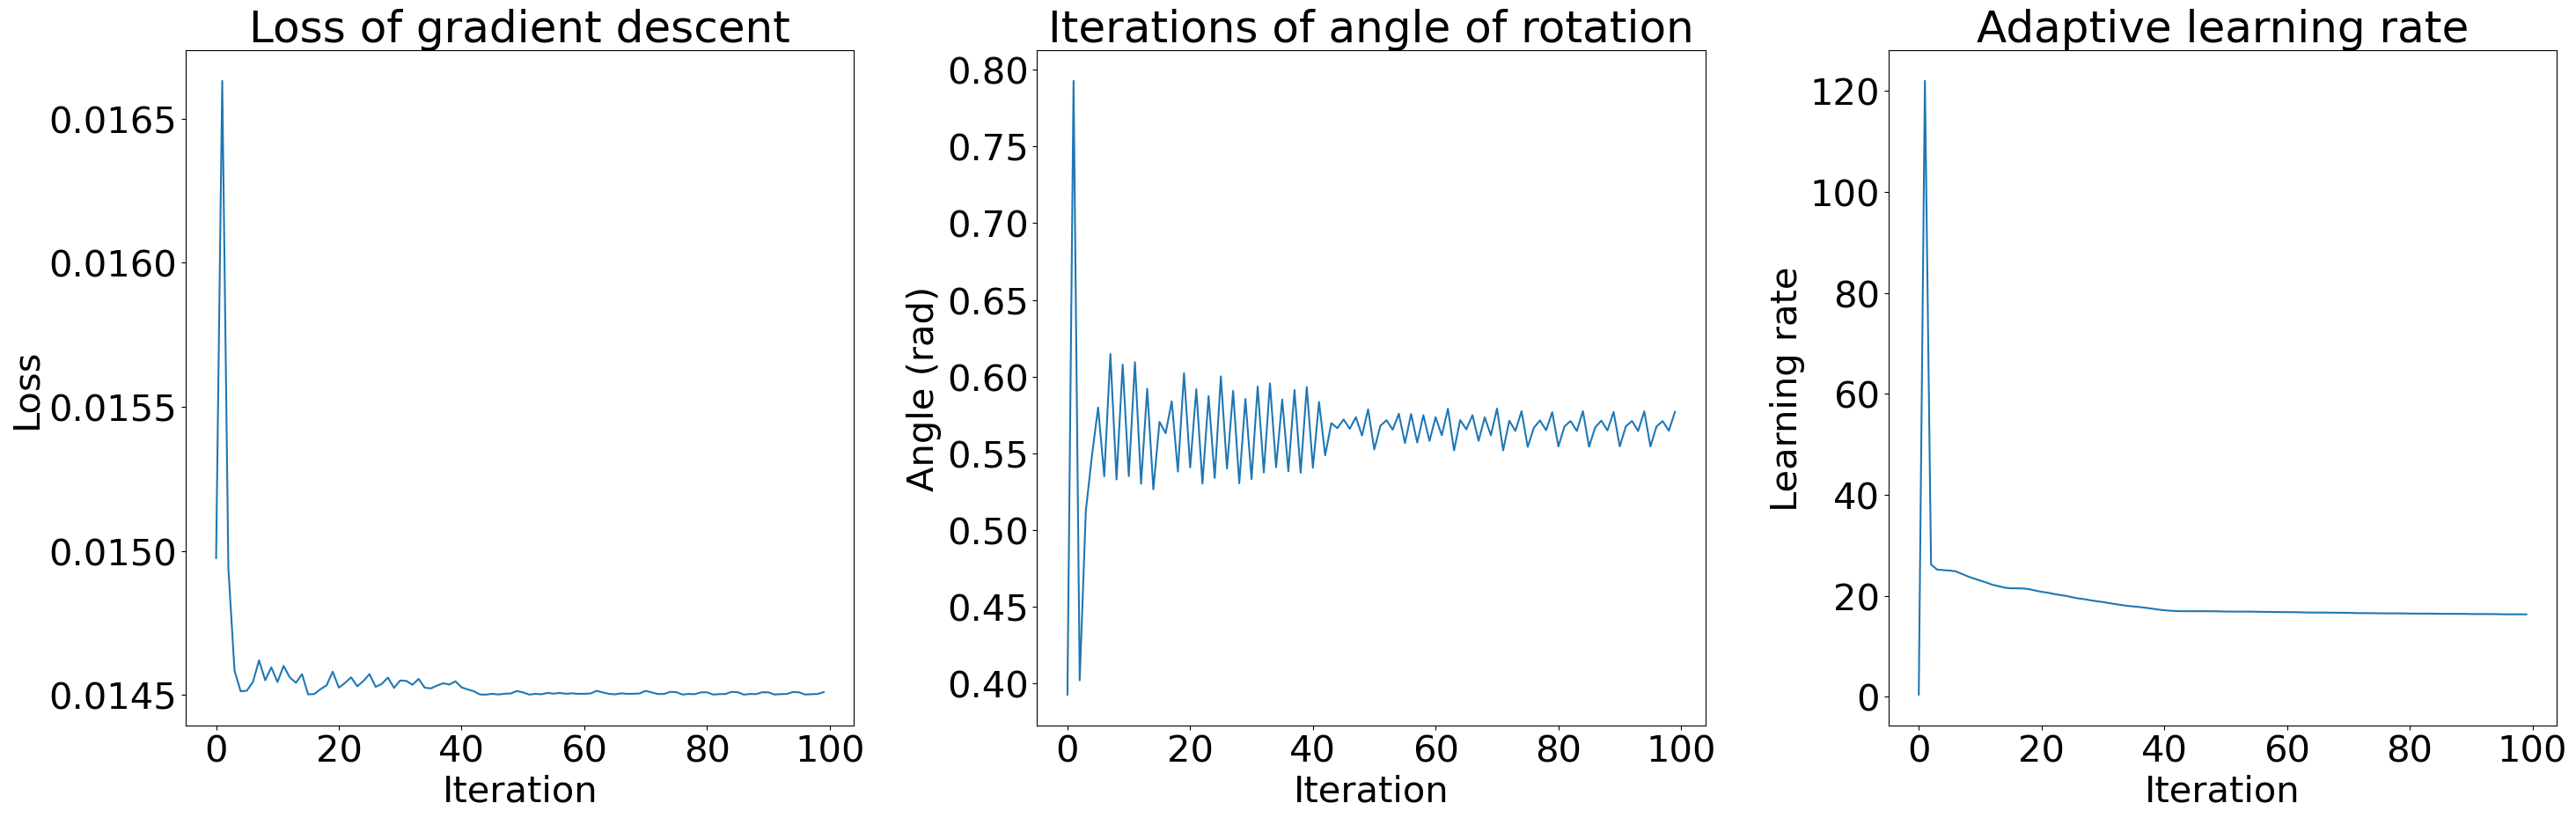

In [108]:
matplotlib.rcParams.update({'font.size': 30})
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].plot(history_arr[:,0])
axes[0].set_title('Loss of gradient descent')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

axes[1].plot(history_arr[:,1])
axes[1].set_title('Iterations of angle of rotation')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Angle (rad)')

axes[2].plot(history_arr[:,2])
axes[2].set_title('Adaptive learning rate')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Learning rate')

plt.tight_layout()

fig.savefig('grad_desc_history_blfup')

In [98]:
theta

np.float64(0.5770600449703588)

In [99]:
final_image = rotate_image(theta, img_fup[:,:,200])

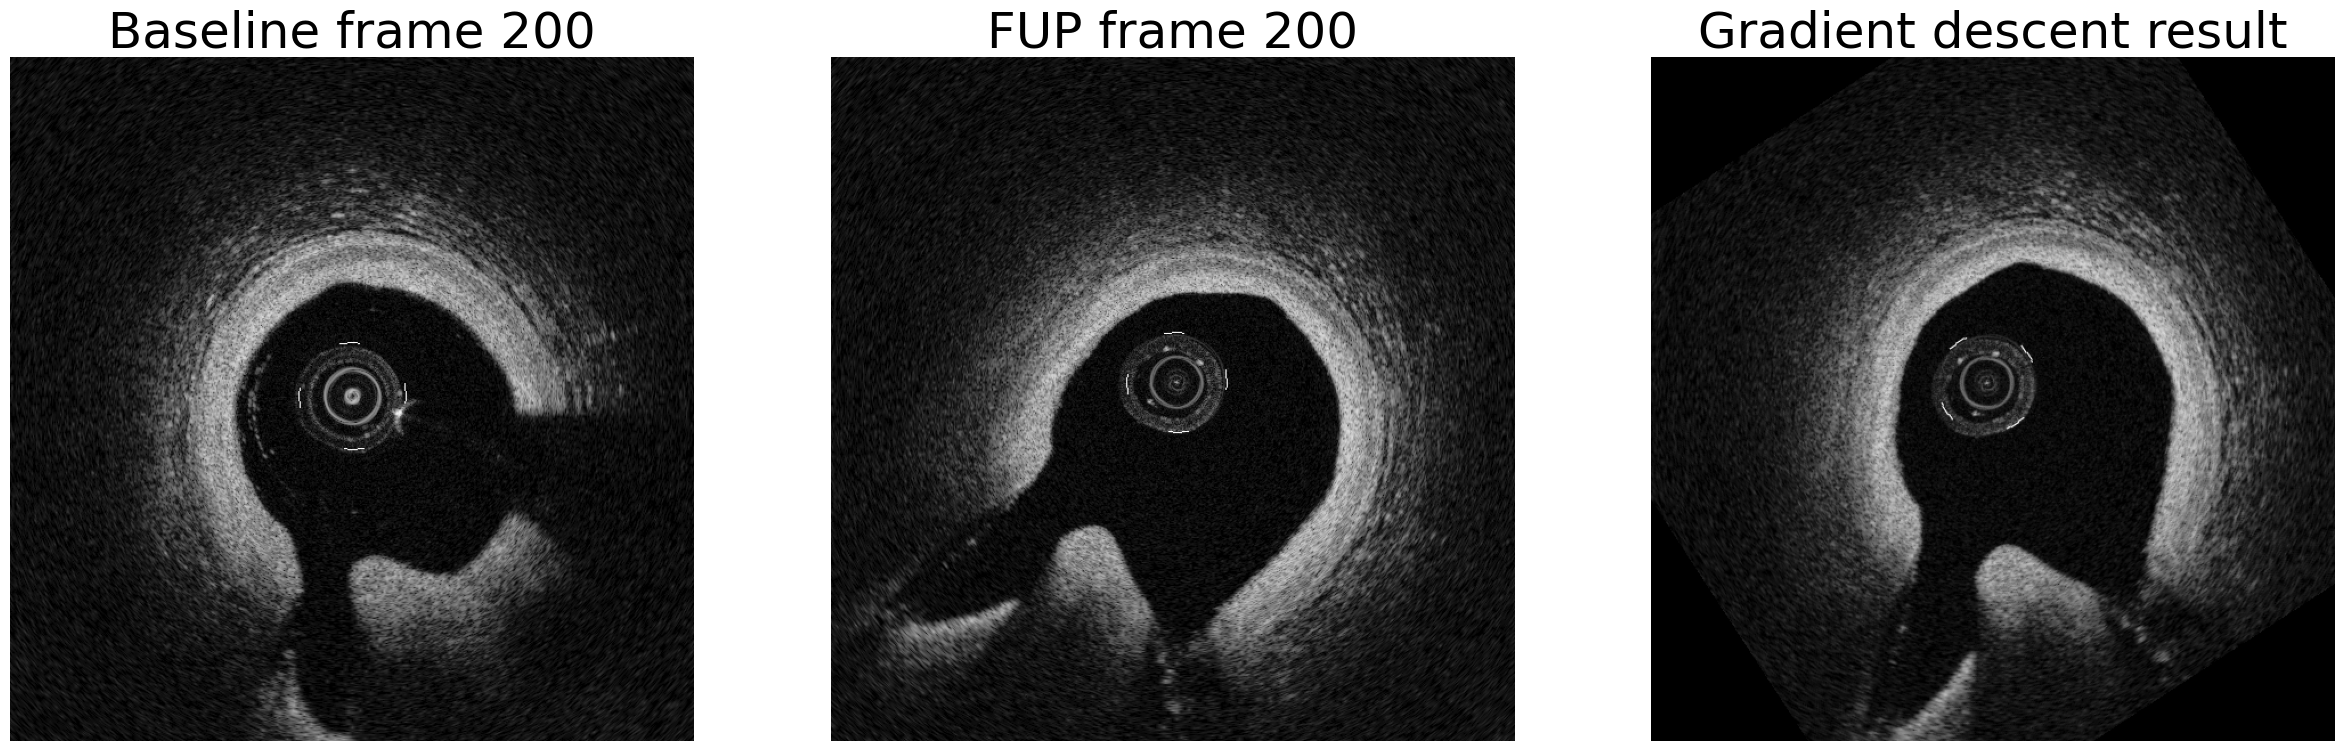

In [109]:
matplotlib.rcParams.update({'font.size': 30})
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].imshow(img_bl[:,:,200], cmap='Grays_r')
axes[0].set_title('Baseline frame 200')
axes[0].set_axis_off()

axes[1].imshow(img_fup[:,:,200], cmap='Grays_r')
axes[1].set_title('FUP frame 200')
axes[1].set_axis_off()

axes[2].imshow(final_image, cmap='Grays_r')
axes[2].set_title('Gradient descent result')
axes[2].set_axis_off()

plt.savefig('registration_blfup')